<a href="https://colab.research.google.com/github/Sumisumisumith/Kickmotion-Evaluation-System/blob/main/StridedTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ファイルにstrided transformerをクローン
"""
%cd /content/drive/MyDrive/MyColab
!git clone https://github.com/Vegetebird/StridedTransformer-Pose3D.git
"""

/content/drive/MyDrive/MyColab
Cloning into 'StridedTransformer-Pose3D'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 226 (delta 36), reused 47 (delta 24), pack-reused 165
Receiving objects: 100% (226/226), 28.37 MiB | 7.54 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [ ]:
#StridedTransformer-Pose3Dに必要なライブラリをインストール

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!pip install --upgrade gdown
!pip install yacs
!pip install filterpy
!pip install einops
!pip install yt-dlp moviepy
!pip install matplotlib==3.7.1

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=d357f81feadff521889b96a23628faf8e8e761f742e44191e838b78d9e9033c8
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 797.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 k

In [ ]:
#インストールした各ライブラリをインポート

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

import os
from yt_dlp import YoutubeDL

from moviepy.video.fx.resize import resize
from moviepy.editor import VideoFileClip, AudioFileClip, ImageSequenceClip, CompositeAudioClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D


In [ ]:
#学習済みモデルダウンロード

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D
!mkdir -p ./checkpoint/pretrained

if not os.path.exists('checkpoint/pretrained/refine_4365.pth'):
  !gdown https://drive.google.com/uc?id=1aDLu0SB9JnPYZOOzQsJMV9zEIHg2Uro7 -O checkpoint/pretrained/refine_4365.pth
if not os.path.exists('checkpoint/pretrained/no_refine_4365.pth'):
  !gdown https://drive.google.com/uc?id=1l63AI9BsNovpfTAbfAkySo9X2MOWgYZH -O checkpoint/pretrained/no_refine_4365.pth

if not os.path.exists('demo/lib/checkpoint/yolov3.weights'):
  !gdown https://drive.google.com/uc?id=1gWZl1VrlLZKBf0Pfkj4hKiFxe8sHP-1C -O demo/lib/checkpoint/yolov3.weights
if not os.path.exists('demo/lib/checkpoint/pose_hrnet_w48_384x288.pth'):
  !gdown https://drive.google.com/uc?id=1CpyZiUIUlEjiql4rILwdBT4666S72Oq4 -O demo/lib/checkpoint/pose_hrnet_w48_384x288.pth

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D


In [ ]:
##vis.py実行
%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!python demo/vis.py --video kickmotion_0003_L.mov

#出力結果はoutputのフォルダ内

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D
/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/lib/sort/sort.py:16: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iou(bb_test, bb_gt):

Generating 2D pose...
100% 241/241 [00:35<00:00,  6.77it/s]
Generating 2D pose successful!

Generating 3D pose...
  8% 20/241 [00:12<02:11,  1.68it/s]/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/vis.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figu

In [ ]:
#StridedTransformer/demo/videoに、youtubeから切り取った入力動画を配置

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

video_url = 'https://youtu.be/0wVKezD0Czw' #@param {type:"string"}

#@markdown 動画の切り抜き範囲(秒)を指定してください。\
#@markdown 30秒以上の場合OOM発生の可能性が高いため注意
start_sec =  0#@param {type:"integer"}
end_sec =  8#@param {type:"integer"}

(start_pt, end_pt) = (start_sec, end_sec)

download_resolution = 360
full_video_path = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/full_video.mp4'
file_name = 'input_clip.mp4'
input_clip_path = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/' + file_name

# 動画ダウンロード
ydl_opts = {'format': f'best[height<={download_resolution}]', 'overwrites': True, 'outtmpl': full_video_path}
with YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])

# 指定区間切り抜き
with VideoFileClip(full_video_path) as video:
    subclip = video.subclip(start_pt, end_pt)
    subclip.write_videofile(input_clip_path)

In [ ]:
#入力ファイルを指定してvis.pyを実行する(実行結果はStridedTransformer/demo/output/input_clip/input_clip.mp4)

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!python demo/vis.py --video {file_name}

output = VideoFileClip('/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/output/input_clip/input_clip.mp4')
output = resize(output, height=420)
output.ipython_display()

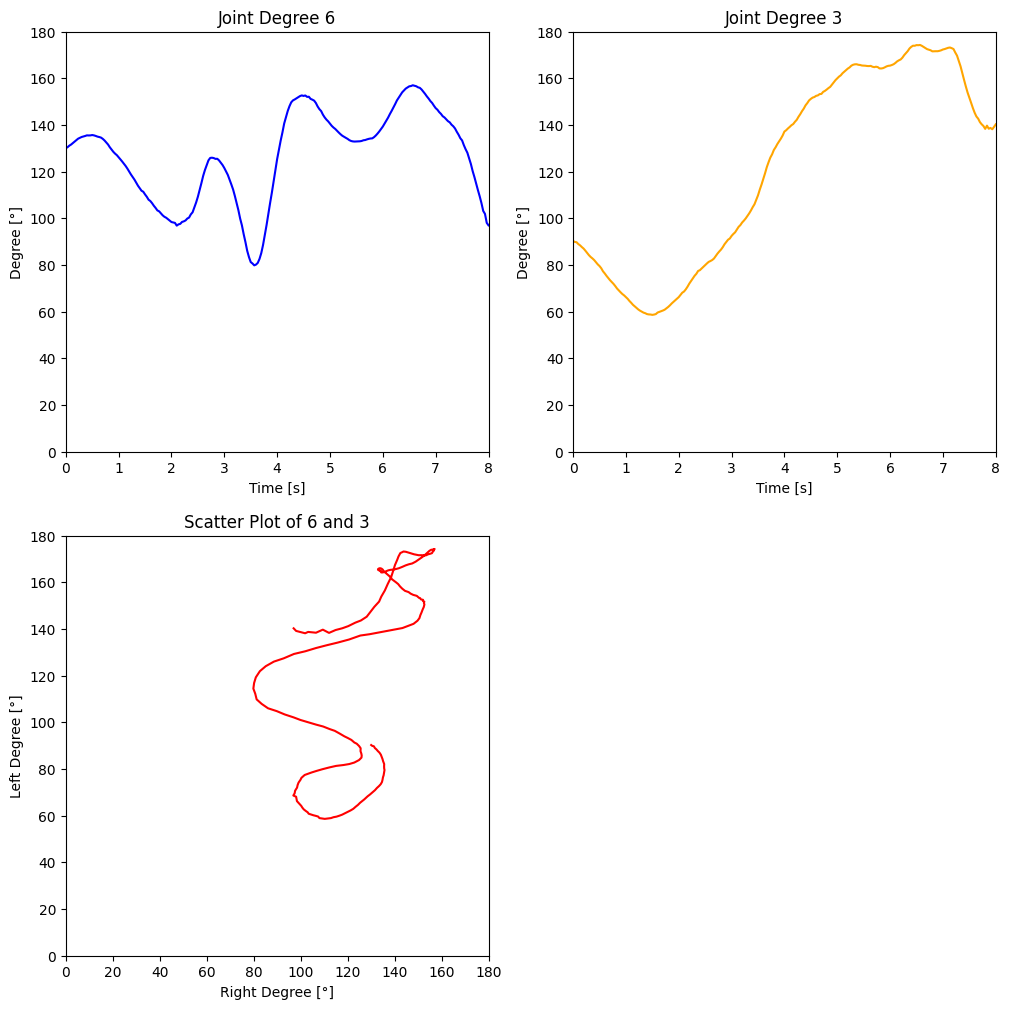

In [ ]:
#関節角度＆速度の計算
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# 17行3列ずつデータを読み取る関数
def read_3d_data(file, batch_size=17):
    data = []
    with open(file, mode='r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        batch = []
        for row in reader:
            batch.append([float(val) for val in row])
            if len(batch) == batch_size:
                data.append(batch)
                batch = []
    return data

# 関節角度を計算する関数
def joint_deg(data, joint_num):
    deg = []
    joint_num = joint_num - 1
    for frame in range(len(data)):
        a = data[frame][joint_num - 1] - data[frame][joint_num]
        b = data[frame][joint_num + 1] - data[frame][joint_num]
        x = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        rad = math.acos(x)
        deg.append(math.degrees(rad))
    return deg

# 関節速度を計算する関数
def joint_v(data,joint_num):
    v = []
    joint_num = joint_num - 1
    for frame in range(len(data)-1):
        d = data[frame+1][joint_num] - data[frame][joint_num]
        v.append(np.linalg.norm(d))
    return v


# CSVファイル名
csv_filename = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/kickmotion_0003_L.csv'#@param {type:"string"}

# 三次元関節座標データの読み込み
data = read_3d_data(csv_filename)
data = np.array(data) #tuple型から変換

fig = plt.figure(figsize=(12,12)) #グラフ用意

# 右足関節角度グラフ表示
joint_deg_right_num = 6#@param {type:"integer"}
deg_right = joint_deg(data, joint_deg_right_num)
t = np.arange(len(data))/30

ax_deg_3 = fig.add_subplot(2, 2, 1)
ax_deg_3.set_title("Joint Degree " + str(joint_deg_right_num))
ax_deg_3.set_xlabel("Time [s]")
ax_deg_3.set_ylabel("Degree [°]")
ax_deg_3.set_xlim([0, 8])
ax_deg_3.set_ylim([0, 180])
ax_deg_3.plot(t, deg_right, color="blue")

# 左足関節角度グラフ表示
joint_deg_left_num = 3#@param {type:"integer"}
deg_left = joint_deg(data, joint_deg_left_num)
t = np.arange(len(data))/30

ax_deg_3 = fig.add_subplot(2, 2, 2)
ax_deg_3.set_title("Joint Degree " + str(joint_deg_left_num))
ax_deg_3.set_xlabel("Time [s]")
ax_deg_3.set_ylabel("Degree [°]")
ax_deg_3.set_xlim([0, 8])
ax_deg_3.set_ylim([0, 180])
ax_deg_3.plot(t, deg_left, color="orange")

"""
# 関節速度グラフ表示
joint_deg_num2 = 6
v = joint_v(data, joint_v_num)
t = np.arange(len(data)-1)

ax_v_3 = fig.add_subplot(2, 2, 2)
ax_v_3.set_title("Joint Velocity " + str(joint_v_num))
ax_v_3.set_xlabel("Time [frame]")
ax_v_3.set_ylabel("Velocity  [distans/frame]")
ax_v_3.set_xlim([0, 240])
ax_v_3.set_ylim([0, 0.1])
ax_v_3.plot(t, v, color="orange")
"""

# 関節角度＆角度の散布図表示
ax_v_3 = fig.add_subplot(2, 2, 3)
ax_v_3.set_title("Scatter Plot of " + str(joint_deg_right_num) + " and " + str(joint_deg_left_num))
ax_v_3.set_xlabel("Right Degree [°]")
ax_v_3.set_ylabel("Left Degree [°]")
ax_v_3.set_xlim([0, 180])
ax_v_3.set_ylim([0, 180])
ax_v_3.plot(deg_right, deg_left, color="red")

plt.show()

In [ ]:
#vis.pyのpost_outから得た関節情報から3Dグラフを作成
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML

# CSVファイル名
csv_filename = '/content/output.csv'

# 17行3列のデータを読み取る関数
def read_3d_data(file, batch_size=17):
    data = []
    with open(file, mode='r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        batch = []
        for row in reader:
            batch.append([float(val) for val in row])
            if len(batch) == batch_size:
                data.append(batch)
                batch = []
    return data

# 三次元座標データの読み込み
data = read_3d_data(csv_filename)
data = np.array(data) #tuple型から変換

# プロットの準備
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=15., azim=70)

# タイトルを設定
frame_number = 0  # 初期フレーム数
title = ax.set_title("frame")

ax.set_xlim([-0.8, 0.8])  # x軸の範囲を設定
ax.set_ylim([-0.8, 0.8])  # y軸の範囲を設定
ax.set_zlim([0, 1.6])  # z軸の範囲を設定

# X、Y、Z軸にラベルを設定
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

sc = ax.scatter([], [], [], marker='o')

# フレーム更新用の関数
def update(frame):

    sc._offsets3d = (data[frame][:, 0], data[frame][:, 1], data[frame][:, 2])

    # タイトルを更新
    title.set_text('frame={}'.format(frame))

    # 凡例を追加
    for text in ax.texts: #前フレームの凡例を削除
        text.set_visible(False)

    for i, (x, y, z) in enumerate(zip(data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]), start=1): #現フレームの凡例作成
        ax.text(x, y, z, str(i), fontsize=8, ha='center', va='center')

    return sc, title

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=len(data), blit=False)

# 動画ファイルの保存
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('/content/output.mp4', writer=writer)

# プロットの表示（任意）
plt.show()

In [ ]:
#フォルダの削除
import shutil

directory = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/StridedTransformer'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

#同名のフォルダを作成する
#os.mkdir(directory)

In [ ]:
#pythonのバージョン確認

!python --version

Python 3.10.12


In [ ]:
%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!git remote remove origin
!git init
!git remote add origin https://github.com/Sumisumisumith/Kickmotion-Evaluation-System.git
!git add .
!git commit -m "Initial commit"
!git push -u origin main

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D
Reinitialized existing Git repository in /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/.git/


In [ ]:
##動画スロー化
import cv2

# 動画を読み込み、FPSを変更して別名で保存する関数
def m_speed_change(path_in, path_out, scale_factor, color_flag):
    # 動画読み込みの設定
    movie = cv2.VideoCapture(path_in)

    # 動画ファイル保存用の設定
    fps = int(movie.get(cv2.CAP_PROP_FPS))                                  # 元動画のFPSを取得
    fps_new = int(fps * scale_factor)                                       # 動画保存時のFPSはスケールファクターをかける
    w = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))                            # 動画の横幅を取得
    h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))                           # 動画の縦幅を取得
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')                     # 動画保存時のfourcc設定（mp4用）
    video = cv2.VideoWriter(path_out, fourcc, fps_new, (w, h), color_flag)  # 動画の仕様（ファイル名、fourcc, FPS, サイズ）

    # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
    while True:
        ret, frame = movie.read()        # フレームを取得
        video.write(frame)               # 動画を保存する
        # フレームが取得できない場合はループを抜ける
        if not ret:
            break
    # 撮影用オブジェクトとウィンドウの解放
    movie.release()
    return

path_in = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/video.MOV'          # 元動画のパス
path_out = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/slow_video.mp4'      # 保存する動画のパス
scale_factor = 0.125              # FPSにかけるスケールファクター
color_flag = True               # カラー動画はTrue, グレースケール動画はFalse

# 動画の再生速度を変更する関数を実行
m_speed_change(path_in, path_out, scale_factor, color_flag)